In [76]:
import xarray as xr
from pathlib import Path
import cfgrib
import numpy as np
import matplotlib.pyplot as plt

Some outstanding questions / Todo items

* Merge Wholesale1 and 2 (2 includes dswrf, lcc, mcc, and hcc)
* Remove dimensions we don't care about (e.g. select temperature at 1 meter, not 0 meters)
* Do we need to combine all the DataArrays into a single DataArray (with "variable" being a dimension?).  The upside is that then a single Zarr chunk can include multiple variables.  The downside is that we lose the metadata (but that's not a huge problem, maybe?)

In [121]:
# Define geographical domain for UKV

KM_TO_M = 1000
DY = DX = 2 * KM_TO_M
NORTH = 1223 * KM_TO_M
SOUTH = -185 * KM_TO_M
WEST = -239 * KM_TO_M
EAST = 857 * KM_TO_M

# Note that the UKV NWPs y is top-to-bottom
NORTHING = np.arange(start=NORTH, stop=SOUTH, step=-DY, dtype=np.int32)
EASTING = np.arange(start=WEST, stop=EAST, step=DX, dtype=np.int32)

NUM_ROWS = len(NORTHING)
NUM_COLS = len(EASTING)

In [2]:
NWP_PATH = Path("/home/jack/Data/NWP/01")

In [3]:
filenames = list(NWP_PATH.glob("*Wholesale1.grib"))

In [49]:
%%time

# The grib files are "heterogeneous", so we use cfgrib.open_datasets
# to return a list of contiguous xr.Datasets.
# See https://github.com/ecmwf/cfgrib#automatic-filtering
datasets = cfgrib.open_datasets(
    filenames[0],

    # Wind direction and wind speed are the only variables which are at 
    # 10 meters above ground in the UKV GRIB files.
    #backend_kwargs={'filter_by_keys': {'level': 10}}
    #backend_kwargs=dict(filter_by_keys={'stepType': 'accum'})
)

ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'
ecCodes provides no latitudes/longitudes for gridType='transverse_mercator'


CPU times: user 115 ms, sys: 4.76 ms, total: 120 ms
Wall time: 115 ms


In [50]:
len(datasets)

6

In [130]:
for ds in datasets:
    print(ds.keys())
    print()
    print()

KeysView(<xarray.Dataset>
Dimensions:            (step: 37, heightAboveGround: 2, values: 385792)
Coordinates:
    time               datetime64[ns] 2021-01-01T21:00:00
  * step               (step) timedelta64[ns] 00:00:00 ... 1 days 12:00:00
  * heightAboveGround  (heightAboveGround) float64 0.0 1.0
    valid_time         (step) datetime64[ns] 2021-01-01T21:00:00 ... 2021-01-...
Dimensions without coordinates: values
Data variables:
    t                  (step, heightAboveGround, values) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter)


KeysView(<xarray.Dataset>
Dimensions:            (step: 37, values: 385792)
Coordinates:
    time               datetime64[ns] 2021-01-01T21:00:00
  * step               (step) timedelta64[ns] 00:00:00 ... 1 days 12:00:00
    heightAbove

## Convert 1D into 2D array

In [191]:
ds = datasets[0]
ds

<xarray.Dataset>
Dimensions:            (step: 37, heightAboveGround: 2, values: 385792)
Coordinates:
    time               datetime64[ns] 2021-01-01T21:00:00
  * step               (step) timedelta64[ns] 00:00:00 ... 1 days 12:00:00
  * heightAboveGround  (heightAboveGround) float64 0.0 1.0
    valid_time         (step) datetime64[ns] 2021-01-01T21:00:00 ... 2021-01-...
Dimensions without coordinates: values
Data variables:
    t                  (step, heightAboveGround, values) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter

In [192]:
ds = ds.sel(heightAboveGround=1)

In [193]:
ds = ds.drop_vars(['heightAboveGround', 'valid_time'])

For each `step`, the pixel values in the grib files represent a 2D image.  But, in the grib, the values are in a flat 1D array (indexed by the `values` dimension).  The ordering of the pixels are row_0, row_1, row_2, etc.


We reshape every data variable at once using this trick, adapted from https://stackoverflow.com/a/62667154

In [194]:
%%time

# Don't reshape yet.  Instead just create new coordinates,
# which give the `x` and `y` position of each position in the `values` dimension:
ds = ds.assign_coords(
    {
        'x': ('values', np.tile(EASTING, reps=NUM_ROWS)), 
        'y': ('values', np.repeat(NORTHING, repeats=NUM_COLS))
    })

CPU times: user 2.37 ms, sys: 0 ns, total: 2.37 ms
Wall time: 2.38 ms


In [195]:
ds

<xarray.Dataset>
Dimensions:  (step: 37, values: 385792)
Coordinates:
    time     datetime64[ns] 2021-01-01T21:00:00
  * step     (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
    x        (values) int32 -239000 -237000 -235000 ... 851000 853000 855000
    y        (values) int32 1223000 1223000 1223000 ... -183000 -183000 -183000
Dimensions without coordinates: values
Data variables:
    t        (step, values) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter

In [189]:
%%time

# Now set "values" to be a MultiIndex, indexed by `y` and `x`:
ds = ds.set_index(values=("y", "x"))

CPU times: user 13.7 ms, sys: 3.62 ms, total: 17.3 ms
Wall time: 15.8 ms


In [190]:
ds

<xarray.Dataset>
Dimensions:  (step: 37, values: 385792)
Coordinates:
    time     datetime64[ns] 2021-01-01T21:00:00
  * step     (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * values   (values) MultiIndex
  - y        (values) int64 1223000 1223000 1223000 ... -183000 -183000 -183000
  - x        (values) int64 -239000 -237000 -235000 ... 851000 853000 855000
Data variables:
    t        (step, values) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter

In [182]:
%%time

# Now unstack.  This gets rid of the `values` dimension and indexes
# the data variables using `y` and `x`.
ds = ds.unstack("values")

CPU times: user 51.9 ms, sys: 12 ms, total: 63.9 ms
Wall time: 62 ms


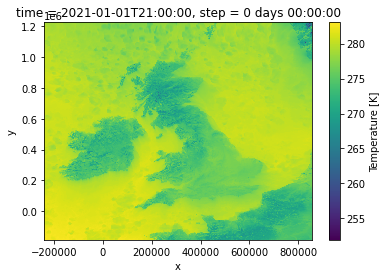

In [183]:
ds["t"].isel(step=0).plot.imshow()

## Clean up "unknowns"

In [196]:
for ds in datasets:
    if 'unknown' in ds:
        del ds['unknown']

## Merge

In [132]:
%%time
ds = xr.merge(datasets)

CPU times: user 10.9 ms, sys: 0 ns, total: 10.9 ms
Wall time: 10.2 ms


In [133]:
ds

<xarray.Dataset>
Dimensions:            (step: 37, heightAboveGround: 2, values: 385792)
Coordinates:
  * step               (step) timedelta64[ns] 00:00:00 ... 1 days 12:00:00
    time               datetime64[ns] 2021-01-01T21:00:00
  * heightAboveGround  (heightAboveGround) float64 0.0 1.0
    valid_time         (step) datetime64[ns] 2021-01-01T21:00:00 ... 2021-01-...
    meanSea            float64 0.0
    surface            float64 0.0
Dimensions without coordinates: values
Data variables:
    t                  (step, heightAboveGround, values) float32 ...
    r                  (step, values) float32 ...
    dpt                (step, values) float32 ...
    vis                (step, values) float32 ...
    si10               (step, values) float32 ...
    wdir10             (step, values) float32 ...
    prmsl              (step, values) float32 ...
    prate              (step, values) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter